In [1]:
import pandas
import datetime
import numpy
from sklearn import linear_model
import scipy.stats as stats
from scipy.optimize import curve_fit
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
from matplotlib import rcParams

In [2]:
# setup some cutoff values we'll use in the analysis
velCutoffUpper = 2000.
velCutoffLower = 0.
numPointsCutoffMLTMLAT = 250
mlatCutOffUpper = 70.
probOccCutoff = 0.2

In [3]:
velGmagDF = pandas.read_csv("../data/processed-vels-geomag.txt", sep=' ')
velGmagDF = velGmagDF.drop('Unnamed: 0', axis=1)
# Discard unwanted values
# We'll only consider those velocities 
# which lie between 0 and 2500 m/s
# and located below 70 MLAT
velGmagDF = velGmagDF[ (velGmagDF["vSaps"] > velCutoffLower) \
                        & (velGmagDF["vSaps"] < velCutoffUpper)\
                       ].reset_index(drop=True)
velGmagDF = velGmagDF[ velGmagDF["MLAT"] < mlatCutOffUpper ].reset_index(drop=True)
# Now filter out velocities which have very few rate of occ.
# We calculat the prob and remove every measurement below 0.2 prob of occ.
mlatMLTDstCountDF = velGmagDF.groupby( ["MLAT", "normMLT", "dst_bin"] )["vSaps"].count().reset_index()
mlatMLTDstCountDF.columns = [ "MLAT", "normMLT", "dst_bin", "count" ]
dstMaxCntDF = mlatMLTDstCountDF.groupby( ["dst_bin"] )["count"].max().reset_index()
dstMaxCntDF.columns = [ "dst_bin", "maxCntDst" ]
mlatMLTDstCountDF = pandas.merge( mlatMLTDstCountDF, dstMaxCntDF, on=[ "dst_bin" ] )
mlatMLTDstCountDF["probOcc"] = mlatMLTDstCountDF["count"]/mlatMLTDstCountDF["maxCntDst"]
mlatMLTDstCountDF = mlatMLTDstCountDF[ mlatMLTDstCountDF["probOcc"] > probOccCutoff ].reset_index(drop=True)
# Filter out MLATs and MLTs (at the Dst bins)
# where number of measurements is low. We do
# this by merging the mlatMLTDstCountDF with velDF.
velGmagDF = pandas.merge( velGmagDF,\
                         mlatMLTDstCountDF,\
                         on=[ "MLAT", "normMLT", "dst_bin" ] )
velGmagDF = velGmagDF[ [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count", "maxCntDst" ] ]
# Divide the velocities into bins
velBins = [ v for v in range(0,int(velCutoffUpper)+100,100) ]
velGmagDF = pandas.concat( [ velGmagDF, \
                    pandas.cut( velGmagDF["vSaps"], \
                               bins=velBins ) ], axis=1 )
velGmagDF.columns = [ "normMLT", "MLAT", "vSaps",\
                        "azim", "dst_bin", "dst_index", "count",\
                         "maxCntDst", "vel_bin" ]
# velGmagDF.head()
# Get a DF with mean Dst in each bin
dstMeanDF = velGmagDF.groupby( ["dst_bin"] ).mean()["dst_index"].astype(int).reset_index()
dstMeanDF.columns = [ "dst_bin", "dst_mean" ]
velGmagDF = pandas.merge( velGmagDF, dstMeanDF, on=["dst_bin"] )
velGmagDF = velGmagDF.sort( ["dst_mean"], ascending=False ).reset_index(drop=True)
# maxSapsVel = numpy.ceil( velGmagDF["vSaps"].max()/1000 ) * 1000.
# velGmagDF["norm_vels"] = velGmagDF["vSaps"]/maxSapsVel
velGmagDF.head()

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:32: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,normMLT,MLAT,vSaps,azim,dst_bin,dst_index,count,maxCntDst,vel_bin,dst_mean
0,1.0,58.0,927.34,-12.52,"(-10, 10]",-6.0,293,508,"(900, 1000]",-3
1,-3.0,61.0,755.23,-17.91,"(-10, 10]",-8.0,277,508,"(700, 800]",-3
2,-3.0,61.0,743.78,-17.19,"(-10, 10]",-8.0,277,508,"(700, 800]",-3
3,-3.0,61.0,800.52,-14.51,"(-10, 10]",-8.0,277,508,"(800, 900]",-3
4,-3.0,61.0,535.88,-19.86,"(-10, 10]",-8.0,277,508,"(500, 600]",-3


In [4]:
# Now fir a rayleigh normal distribution for the velocities
# at every MLT, MLAT and dst_bin! Store the results in a DF
fitShapeArr = []
fitShapeBArr = []
fitLocArr = []
fitScaleArr = []
normMLTArr = []
mlatArr = []
dstBinArr = []
dstMeanArr = []
uniqMLTs = velGmagDF["normMLT"].unique().tolist()
uniqMLATs = velGmagDF["MLAT"].unique().tolist()
uniqDstBins = velGmagDF["dst_bin"].unique().tolist()
for currMlt in uniqMLTs:
    for currMlat in uniqMLATs:
        for currDstBin in uniqDstBins:
            subDF = velGmagDF[ (velGmagDF["normMLT"] == currMlt) & \
                  (velGmagDF["dst_bin"] == currDstBin) & \
                  (velGmagDF["MLAT"] == currMlat) ]
            # If we have values in this DF fit a rayleigh distribution
            if subDF.shape[0] > 0:
                shape, loc, scale = stats.gamma.fit(subDF["vSaps"])
                fitShapeArr.append( shape )
                fitLocArr.append( loc )
                fitScaleArr.append( scale )
                normMLTArr.append( currMlt )
                mlatArr.append( currMlat )
                dstBinArr.append( currDstBin )
                dstMeanArr.append( velGmagDF[velGmagDF["dst_bin"] == currDstBin]["dst_mean"].tolist()[0] )
# convert the data to a dataframe
fitDF = pandas.DataFrame(
    {'shape': fitShapeArr,
     'loc': fitLocArr,
     'scale': fitScaleArr,
     'norm_mlt': normMLTArr,
     'mlat': mlatArr,
     'dst_bin': dstBinArr,
     'dst_mean': dstMeanArr,
    })
fitDF.head()
# There are some extreme values in fitDF, take them out
# Some values of shape go beyond 10^8
# fitDF = fitDF[ fitDF["shape"] <= 500. ]
# Save the fitting results to a DF so that we can use it later
fitDF.to_csv( "../data/fit-gamma.txt",\
                      sep=' ', index=False )

In [5]:
# Make a few plots of the fitting to get an estimate of how things are!
# Our velocities range from 0 to 2000 m/s
velsArr = numpy.arange(0.,2100.,100.)
print velsArr
selMLAT = 59.5#59.#
selNormMLT = -3.#-6.#
selFitDF = fitDF[ (fitDF["norm_mlt"] == selNormMLT) &\
                (fitDF["mlat"] == selMLAT) ]
selVelDF = velGmagDF[ (velGmagDF["normMLT"] == selNormMLT) & \
                  (velGmagDF["MLAT"] == selMLAT) ]
# print selFitDF["dst_bin"].unique()

[    0.   100.   200.   300.   400.   500.   600.   700.   800.   900.
  1000.  1100.  1200.  1300.  1400.  1500.  1600.  1700.  1800.  1900.
  2000.]


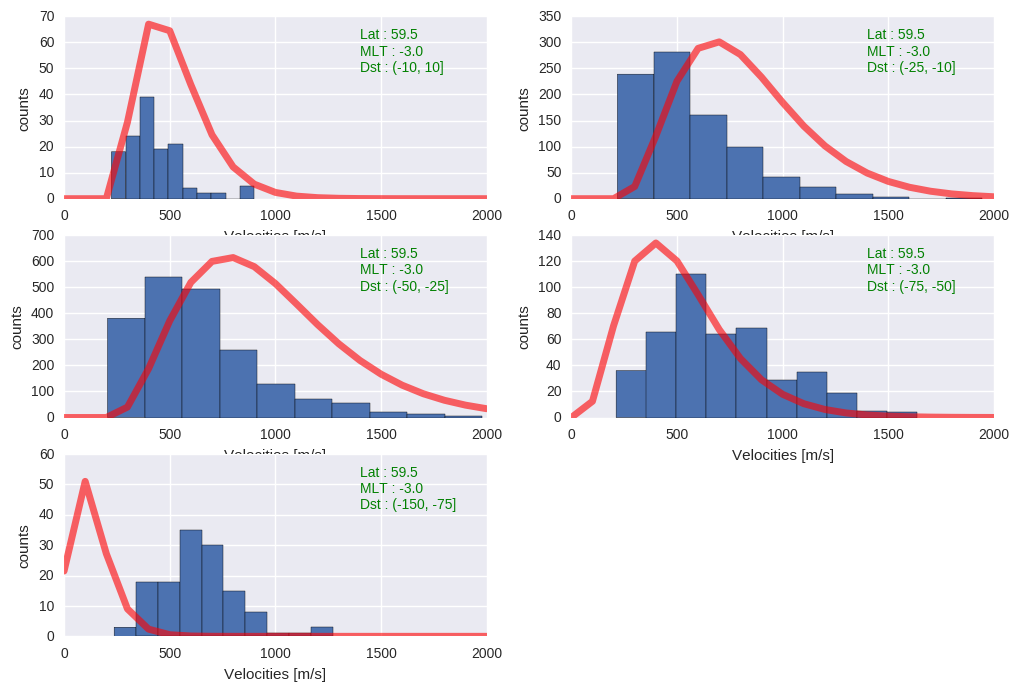

In [10]:
f = plt.figure(figsize=(12, 8))
axArr = []
axArr.append( f.add_subplot(3,2,1) )
axArr.append( f.add_subplot(3,2,2) )
axArr.append( f.add_subplot(3,2,3) ) 
axArr.append( f.add_subplot(3,2,4) )
axArr.append( f.add_subplot(3,2,5) )
for ind, currDstBin in enumerate( selFitDF["dst_bin"].unique() ):
    shapeA = selFitDF[ selFitDF["dst_bin"] == currDstBin ]["shape"].tolist()[0]
    loc = selFitDF[ selFitDF["dst_bin"] == currDstBin ]["loc"].tolist()[0]
    scale = selFitDF[ selFitDF["dst_bin"] == currDstBin ]["scale"].tolist()[0]
    subVelDF = selVelDF[ selVelDF["dst_bin"] == currDstBin ]
    velScale = subVelDF["vSaps"].value_counts(bins=velsArr[::2]).max()
    pdf_fitted = stats.gamma.pdf(velsArr, shape, loc, scale)
    fitVals = pdf_fitted/max(pdf_fitted) * velScale
    axArr[ind].plot(velsArr, fitVals, 'r-', lw=5, alpha=0.6)
    axArr[ind].set_xlabel("Velocities [m/s]")
    axArr[ind].set_ylabel("counts")
    printText = "Lat : " + str(selMLAT) +\
                "\n" + "MLT : " + str(selNormMLT) +\
                "\n" + "Dst : " + currDstBin
    axArr[ind].text(0.7, 0.7,  printText,
            transform=axArr[ind].transAxes,
            color='green', fontsize=10)
    subVelDF["vSaps"].hist(ax=axArr[ind])
plt.savefig("../figs/beta-fit-test.pdf",bbox_inches='tight')

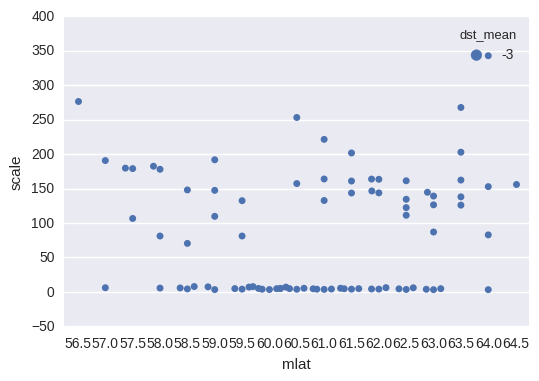

In [22]:
selParam = "scale"
fitDF2 = fitDF[ (fitDF["loc"] > 0.) ]
selDF = fitDF2[ (fitDF2["dst_bin"] == "(-10, 10]") ] # & (fitSgDF["norm_mlt"] == -6.)
# selDF["logvar"] = [ numpy.log10(x) for x in selDF[selParam] ]
sns.swarmplot( x="mlat", y=selParam, hue="dst_mean", data=selDF[ ["mlat", "norm_mlt", "dst_bin", "dst_mean" , selParam] ])

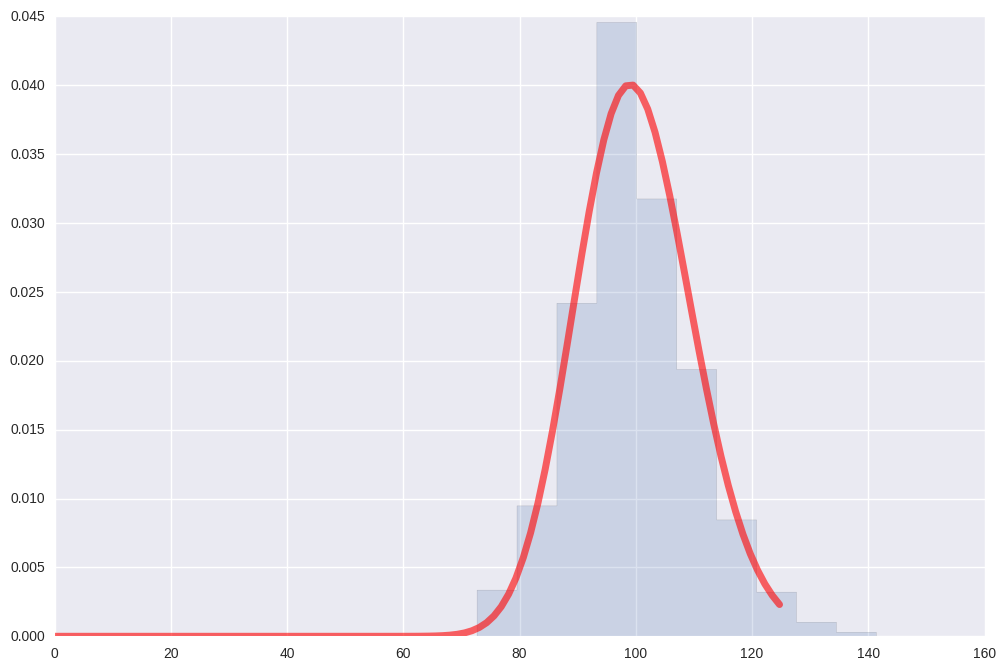

In [8]:
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)

a = 100.
x = numpy.linspace(stats.gamma.ppf(0., a),
              stats.gamma.ppf(0.99, a), 100)

r = stats.gamma.rvs( a, size=1000)
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
ax.plot(x, stats.gamma.pdf(x, a) ,
         'r-', lw=5, alpha=0.6, label='gamma pdf')